# Design of CNN Dental Disease Detection for Zaamigo

## Import Libary yang akan digunakan

In [70]:
import os
import glob
import warnings
import matplotlib.pyplot as plt

import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization

warnings.filterwarnings("ignore")

In [71]:
# Set default random number

import random
from numpy.random import seed
#from tensorflow import set_random_seed

seed(1)
random.seed(1)
#set_random_seed(1)
#tensorflow.random.set_seed(1)

In [72]:
!nvidia-smi

Wed May 24 02:24:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    33W /  70W |  14666MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

# Pre-Processing Citra X-Ray

## Loading data dari GDrive

In [73]:
import os
import random
import shutil

# Define the path to the main folder
main_folder = "/kaggle/input/oral-diseases"

# Define the output path for saving the split dataset
output_folder = "/kaggle/working"

# Define the ratios for training, testing, and validation sets
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

# Iterate through each subfolder within the main folder
for class_folder in os.listdir(main_folder):
    class_folder_path = os.path.join(main_folder, class_folder)

    # Skip if the item is not a directory
    if not os.path.isdir(class_folder_path):
        continue

    # Create train, test, and valid folders within each subfolder
    train_folder = os.path.join(output_folder, "train")
    test_folder = os.path.join(output_folder, "test")
    valid_folder = os.path.join(output_folder, "valid")

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    os.makedirs(valid_folder, exist_ok=True)

    # Iterate through the images folder within each subfolder
    for subfolder in os.listdir(class_folder_path):
        subfolder_path = os.path.join(class_folder_path, subfolder)

        # Skip if the item is not a directory
        if not os.path.isdir(subfolder_path):
            continue

        # Create subfolders within train, test, and valid folders
        train_subfolder = os.path.join(train_folder, class_folder, subfolder)
        test_subfolder = os.path.join(test_folder, class_folder, subfolder)
        valid_subfolder = os.path.join(valid_folder, class_folder, subfolder)

        os.makedirs(train_subfolder, exist_ok=True)
        os.makedirs(test_subfolder, exist_ok=True)
        os.makedirs(valid_subfolder, exist_ok=True)

        # Read the list of images within the subfolder
        image_files = os.listdir(subfolder_path)

        # Shuffle the list of images randomly
        random.shuffle(image_files)

        # Calculate the number of images for each set
        total_images = len(image_files)
        train_count = int(total_images * train_ratio)
        test_count = int(total_images * test_ratio)
        valid_count = total_images - train_count - test_count

        # Copy or move the images to the appropriate folders
        for i, image_file in enumerate(image_files):
            src_path = os.path.join(subfolder_path, image_file)

            if i < train_count:
                dest_path = os.path.join(train_subfolder, image_file)
            elif i < train_count + test_count:
                dest_path = os.path.join(test_subfolder, image_file)
            else:
                dest_path = os.path.join(valid_subfolder, image_file)

            # Copy the image file to the destination folder
            shutil.copy(src_path, dest_path)

print("Dataset splitting is complete.")

Dataset splitting is complete.


In [74]:
#Loading dataset Normal vs Pneumonia baru - For Journal Publishing

train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/valid'
test_dir = '/kaggle/working/test'

## menghitung jumlah data

In [75]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count = 0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count += len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [76]:
train_samples = get_files(train_dir)
val_samples = get_files(val_dir)
test_samples = get_files(test_dir)
num_classes = len(glob.glob(train_dir+"/*"))

print(num_classes, "Jenis Diagnosis")
print(train_samples, "Citra X-Ray data Training")
print(val_samples, "Citra X-Ray data Validation")
print(test_samples, "Citra X-Ray data Testing")

4 Jenis Diagnosis
659 Citra X-Ray data Training
194 Citra X-Ray data Validation
96 Citra X-Ray data Testing


## Preprocessing data.

In [77]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Randomly rotate the images by 20 degrees
    width_shift_range=0.2,  # Randomly shift the width of the images by 20%
    height_shift_range=0.2,  # Randomly shift the height of the images by 20%
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'  # Fill any newly created pixels after rotation or shifting
)


test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Randomly rotate the images by 20 degrees
    width_shift_range=0.2,  # Randomly shift the width of the images by 20%
    height_shift_range=0.2,  # Randomly shift the height of the images by 20%
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'  # Fill any newly created pixels after rotation or shifting
)


## Mengatur Ukuran serta warna dari input


In [78]:
img_width,img_height = 256, 256
input_shape = (img_width, img_height,3)
batch_size = 32

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_width,img_height),
                                                    batch_size=batch_size,
                                                    color_mode='rgb')

validation_generator = train_datagen.flow_from_directory(val_dir, #dalam direktori yang sama dengan data training
                                                         target_size = (img_height, img_width),
                                                         batch_size = batch_size,
                                                         color_mode='rgb')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_width,img_height),
                                                  batch_size=batch_size,
                                                  color_mode='rgb')

Found 655 images belonging to 4 classes.
Found 190 images belonging to 4 classes.
Found 92 images belonging to 4 classes.


In [79]:
# Label pada masing-masing kelas
train_generator.class_indices

{'Gingivitis Original Dataset': 0,
 'caries orignal data set': 1,
 'tooth discoloration original dataset': 2,
 'ulcer original dataset': 3}

# Arsitektur Convolutional Neural Network

In [80]:
# Arsitektur UBNet V2.
"""
model = Sequential()
model.add(Conv2D(16, (3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
"""

"\nmodel = Sequential()\nmodel.add(Conv2D(16, (3,3), padding='same', input_shape=input_shape, activation='relu'))\nmodel.add(MaxPooling2D(pool_size=(2,2)))\n\nmodel.add(Conv2D(32, (3,3), padding='same', activation='relu'))\nmodel.add(MaxPooling2D(pool_size=(2,2)))\n\nmodel.add(Conv2D(64, (3,3), padding='same', activation='relu'))\nmodel.add(MaxPooling2D(pool_size=(2,2)))\n\nmodel.add(Conv2D(128, (3,3), padding='same', activation='relu'))\nmodel.add(MaxPooling2D(pool_size=(2,2)))\n\nmodel.add(Flatten())\nmodel.add(Dense(256, activation='relu'))\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dense(num_classes, activation='softmax'))\n\nmodel.summary()\n"

In [81]:
model = Sequential()
model.add(Conv2D(8, (7,7), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(8, (7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, (5,5), padding='same', activation='relu'))
model.add(Conv2D(16, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_127 (Conv2D)         (None, 256, 256, 8)       1184      
                                                                 
 conv2d_128 (Conv2D)         (None, 256, 256, 8)       3144      
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_129 (Conv2D)         (None, 128, 128, 16)      3216      
                                                                 
 conv2d_130 (Conv2D)         (None, 128, 128, 16)      6416      
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                

In [82]:
model = Sequential()
model.add(Conv2D(8, (7,7), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(8, (7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, (5,5), padding='same', activation='relu'))
model.add(Conv2D(16, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_135 (Conv2D)         (None, 256, 256, 8)       1184      
                                                                 
 conv2d_136 (Conv2D)         (None, 256, 256, 8)       3144      
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_137 (Conv2D)         (None, 128, 128, 16)      3216      
                                                                 
 conv2d_138 (Conv2D)         (None, 128, 128, 16)      6416      
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                

In [83]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom fully connected layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Replace `num_classes` with the number of classes in your dataset

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [84]:
train = model.fit_generator(train_generator,
                            epochs=25,
                            steps_per_epoch=train_generator.samples // batch_size,
                            validation_data = validation_generator,
                            validation_steps = validation_generator.samples // batch_size, 
                            verbose=1)

Epoch 1/25
20/20 [==============================] - 18s 854ms/step - loss: 1.3418 - accuracy: 0.3609 - val_loss: 1.3396 - val_accuracy: 0.2937
Epoch 2/25
20/20 [==============================] - 17s 824ms/step - loss: 1.2849 - accuracy: 0.4061 - val_loss: 1.3151 - val_accuracy: 0.3375
Epoch 3/25
20/20 [==============================] - 16s 804ms/step - loss: 1.1341 - accuracy: 0.4912 - val_loss: 1.0726 - val_accuracy: 0.5625
Epoch 4/25
20/20 [==============================] - 16s 807ms/step - loss: 1.1092 - accuracy: 0.4944 - val_loss: 1.0845 - val_accuracy: 0.5188
Epoch 5/25
20/20 [==============================] - 17s 857ms/step - loss: 1.1686 - accuracy: 0.4812 - val_loss: 1.1670 - val_accuracy: 0.5312
Epoch 6/25
20/20 [==============================] - 16s 813ms/step - loss: 1.1439 - accuracy: 0.4944 - val_loss: 1.2501 - val_accuracy: 0.5063
Epoch 7/25
20/20 [==============================] - 16s 810ms/step - loss: 1.0928 - accuracy: 0.5281 - val_loss: 1.0618 - val_accuracy: 0.5562

# Visualisasi Citra X-Ray setelah melalui filter

## Import 1 citra sebagai input filter

In [85]:
"""
from keras.preprocessing import image
import numpy as np
img1 = image.load_img('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0128-0001.jpeg')
plt.imshow(img1);

# pre-processing citra
img1 = image.load_img('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0128-0001.jpeg', target_size=(400,400,1), color_mode='grayscale')
img = image.img_to_array(img1)
img = img/255
img = np.expand_dims(img, axis=0)

print(img)
"""

"\nfrom keras.preprocessing import image\nimport numpy as np\nimg1 = image.load_img('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0128-0001.jpeg')\nplt.imshow(img1);\n\n# pre-processing citra\nimg1 = image.load_img('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0128-0001.jpeg', target_size=(400,400,1), color_mode='grayscale')\nimg = image.img_to_array(img1)\nimg = img/255\nimg = np.expand_dims(img, axis=0)\n\nprint(img)\n"

## Process Filtering

In [86]:
"""
from keras.models import Model
conv2d_1_output = Model(inputs=model.input, output=model.get_layer('conv2d_1').output)
conv2d_1_features = conv2d_1_output.predict(img)
"""

"\nfrom keras.models import Model\nconv2d_1_output = Model(inputs=model.input, output=model.get_layer('conv2d_1').output)\nconv2d_1_features = conv2d_1_output.predict(img)\n"

## Visualisasi terhadap citra

In [87]:
"""
import matplotlib.image as mpig

fig=plt.figure(figsize = (28,14))
columns = 8
rows = 4

for i in range(columns*rows):

    fig.add_subplot(rows,columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_1_features[0, :, :, i], cmap='viridis')
plt.show
"""

"\nimport matplotlib.image as mpig\n\nfig=plt.figure(figsize = (28,14))\ncolumns = 8\nrows = 4\n\nfor i in range(columns*rows):\n\n    fig.add_subplot(rows,columns, i+1)\n    plt.axis('off')\n    plt.title('filter'+str(i))\n    plt.imshow(conv2d_1_features[0, :, :, i], cmap='viridis')\nplt.show\n"

# Training Model CNN

## Training pada Model

In [88]:
opt = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train = model.fit_generator(train_generator,
                            epochs=25,
                            steps_per_epoch=train_generator.samples // batch_size,
                            validation_data = validation_generator,
                            validation_steps = validation_generator.samples // batch_size, 
                            verbose=1)

Epoch 1/25
20/20 [==============================] - 18s 856ms/step - loss: 0.8869 - accuracy: 0.6292 - val_loss: 0.9437 - val_accuracy: 0.5562
Epoch 2/25
20/20 [==============================] - 16s 808ms/step - loss: 0.8428 - accuracy: 0.6388 - val_loss: 0.8553 - val_accuracy: 0.6438
Epoch 3/25
20/20 [==============================] - 16s 805ms/step - loss: 0.8084 - accuracy: 0.6372 - val_loss: 0.8559 - val_accuracy: 0.6375
Epoch 4/25
20/20 [==============================] - 16s 809ms/step - loss: 0.7953 - accuracy: 0.6726 - val_loss: 0.8403 - val_accuracy: 0.6187
Epoch 5/25
20/20 [==============================] - 17s 837ms/step - loss: 0.7721 - accuracy: 0.6886 - val_loss: 0.8717 - val_accuracy: 0.6375
Epoch 6/25
20/20 [==============================] - 15s 745ms/step - loss: 0.7327 - accuracy: 0.6982 - val_loss: 0.8334 - val_accuracy: 0.6187
Epoch 7/25
20/20 [==============================] - 14s 717ms/step - loss: 0.7413 - accuracy: 0.6998 - val_loss: 0.7563 - val_accuracy: 0.6750

# Evaluasi Model

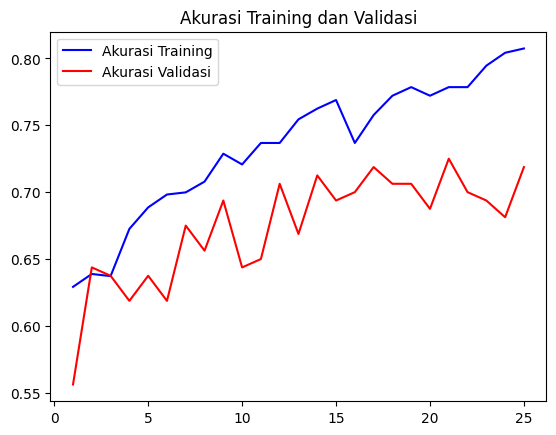

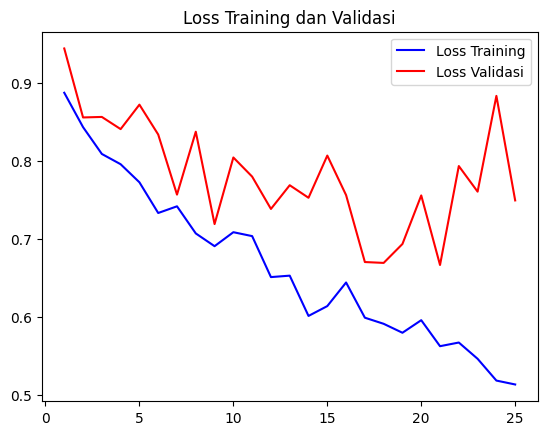

In [99]:
acc = train.history['accuracy']
val_acc = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']

epochs = range(1, len(acc) + 1)

# Akurasi data Training dan Validasi
plt.plot(epochs, acc, 'b', label='Akurasi Training')
plt.plot(epochs, val_acc, 'r', label='Akurasi Validasi')
plt.title('Akurasi Training dan Validasi')
plt.legend()

plt.figure()
# Loss Training dan Validasi
plt.plot(epochs, loss, 'b', label='Loss Training')
plt.plot(epochs, val_loss, 'r', label='Loss Validasi')
plt.title('Loss Training dan Validasi')
plt.legend()
plt.show()

In [90]:
loss, accuracy = model.evaluate(validation_generator, verbose=1)
print("loss Testing adalah {}".format(loss))
print("Akurasi Testing adalah {}".format(accuracy))

6/6 [==============================] - 10s 2s/step - loss: 0.7149 - accuracy: 0.7053
loss Testing adalah 0.71487957239151
Akurasi Testing adalah 0.7052631378173828


In [91]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_width,img_height),
                                                  batch_size=batch_size,
                                                  color_mode='rgb',
                                                  shuffle=False)

#resolt = model.predict_classes(test_generator, batch_size=None, verbose=1)

# Assuming you have already defined your model as 'model'

# Get the predicted probabilities for each class
predictions = model.predict(test_generator, batch_size=None, verbose=1)

# Convert predicted probabilities to class labels
predicted_labels = predictions.argmax(axis=1)

# Print the predicted labels
print(predicted_labels)

Found 92 images belonging to 4 classes.
3/3 [==============================] - 9s 4s/step
[0 0 0 0 0 0 3 0 0 2 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 1 1 1 1 0 3 1 1 1
 2 3 0 1 0 1 2 1 2 2 1 1 0 2 1 1 2 2 2 2 2 2 2 2 2 3 2 2 1 3 3 3 3 3 1 2 3
 1 3 3 3 3 3 3 3 3 2 3 3 2 3 3 3 3 3]


In [92]:
from sklearn import metrics
print(metrics.accuracy_score(test_generator.classes, predicted_labels))

0.7282608695652174


## Confusion Matrix

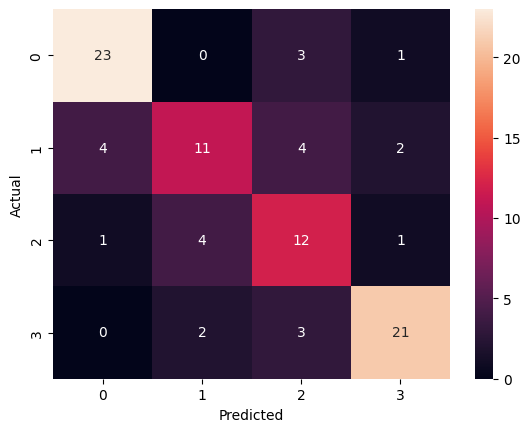

In [93]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


data = {'y_Actual':    test_generator.classes,
        'y_Predicted': predicted_labels
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True, fmt='.0f')
plt.show()

## Menyimpan Weight & Bias Arsitektur Model CNN UBNet

Source : https://www.tensorflow.org/guide/keras/save_and_serialize

In [94]:
# Menyimpan model yan telah dibangun, meliputi : optimizer, architecture, weights dan konfigurasi training
from keras.models import load_model
model.save('covid19-virus-versi4.h5')

# Menyimpan bobot dari model
from keras.models import load_model
model.save_weights('covid19-virus-versi4_weights.h5')

# klasifikasi dari model
classes = train_generator.class_indices
classes

{'Gingivitis Original Dataset': 0,
 'caries orignal data set': 1,
 'tooth discoloration original dataset': 2,
 'ulcer original dataset': 3}

In [102]:
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

acc = train.history['accuracy']
val_acc = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']

epochs = range(1, len(acc) + 1)

# Create the output folder
output_folder = '/kaggle/working/output'
os.makedirs(output_folder, exist_ok=True)

# Plot and save the training chart
plt.plot(epochs, acc, 'b', label='Akurasi Training')
plt.plot(epochs, val_acc, 'r', label='Akurasi Validasi')
plt.title('Akurasi Training dan Validasi')
plt.legend()
plt.savefig(os.path.join(output_folder, 'training_chart.png'))
plt.close()

# Generate and save the confusion matrix heatmap
data = {'y_Actual': test_generator.classes, 'y_Predicted': predicted_labels}
df = pd.DataFrame(data, columns=['y_Actual', 'y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(output_folder, 'confusion_matrix.png'))
plt.close()

# Save the model
model.save(os.path.join(output_folder, 'covid19-virus-versi4.h5'))

# Save the model weights
model.save_weights(os.path.join(output_folder, 'covid19-virus-versi4_weights.h5'))

# Save the class indices
with open(os.path.join(output_folder, 'classes.txt'), 'w') as file:
    for class_name, class_index in classes.items():
        file.write(f'{class_name}: {class_index}\n')

# Create a ZIP file of the output folder
shutil.make_archive('/kaggle/working/output', 'zip', '/kaggle/working/output')

# Create a download link for the ZIP file
output_link = f'<a href="./output.zip" download>Download Output</a>'

<a href="./output" download>Download Output</a>


In [95]:
'''
import numpy as np
import matplotlib.pyplot as plt

# pre-processing test data sama dengan train data
img_width = 406
img_height = 406
#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

from keras.preprocessing import image
def prepare(img_path):
    img = image.load_img(img_path, target_size=(406,406,1),color_mode='grayscale')
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

result = model.predict_classes([prepare('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1007_virus_1690.jpeg')])
disease = image.load_img('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1007_virus_1690.jpeg',target_size=(400,400,1), color_mode='grayscale')
plt.imshow(disease)
print (Classes[int(result)])

'''

"\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# pre-processing test data sama dengan train data\nimg_width = 406\nimg_height = 406\n#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])\n\nfrom keras.preprocessing import image\ndef prepare(img_path):\n    img = image.load_img(img_path, target_size=(406,406,1),color_mode='grayscale')\n    x = image.img_to_array(img)\n    x = x/255\n    return np.expand_dims(x, axis=0)\n\nresult = model.predict_classes([prepare('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1007_virus_1690.jpeg')])\ndisease = image.load_img('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1007_virus_1690.jpeg',target_size=(400,400,1), color_mode='grayscale')\nplt.imshow(disease)\nprint (Classes[int(result)])\n\n"